In [7]:
import warnings
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano

warnings.simplefilter(action="ignore", category=FutureWarning)

In [8]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

Running on PyMC3 v3.11.2
Running on ArviZ v0.11.2


In [9]:
data = pd.read_csv(pm.get_data("radon.csv"))
data["log_radon"] = data["log_radon"].astype(theano.config.floatX)
county_names = data.county.unique()
county_idx = data.county_code.values

n_counties = len(data.county.unique())

In [10]:
data[["county", "log_radon", "floor"]].head()

county  log_radon  floor
0  AITKIN   0.832909    1.0
1  AITKIN   0.832909    0.0
2  AITKIN   1.098612    0.0
3  AITKIN   0.095310    0.0
4   ANOKA   1.163151    0.0

# Pooled/non-hierarchical model

In [11]:
with pm.Model() as pooled_model:

    # Independent parameters for each county
    a = pm.Normal("a", 0, sigma=100)
    b = pm.Normal("b", 0, sigma=100)

    # Model error
    eps = pm.HalfCauchy("eps", 5)

    # Model prediction of radon level
    # a[county_idx] translates to a[0, 0, 0, 1, 1, ...],
    # we thus link multiple household measures of a county
    # to its coefficients.
    radon_est = a + b * data.floor.values

    # Data likelihood
    y = pm.Normal("y", radon_est, sigma=eps, observed=data.log_radon)

In [12]:
with pooled_model:
    pooled_trace = pm.sample(2000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 16 seconds.


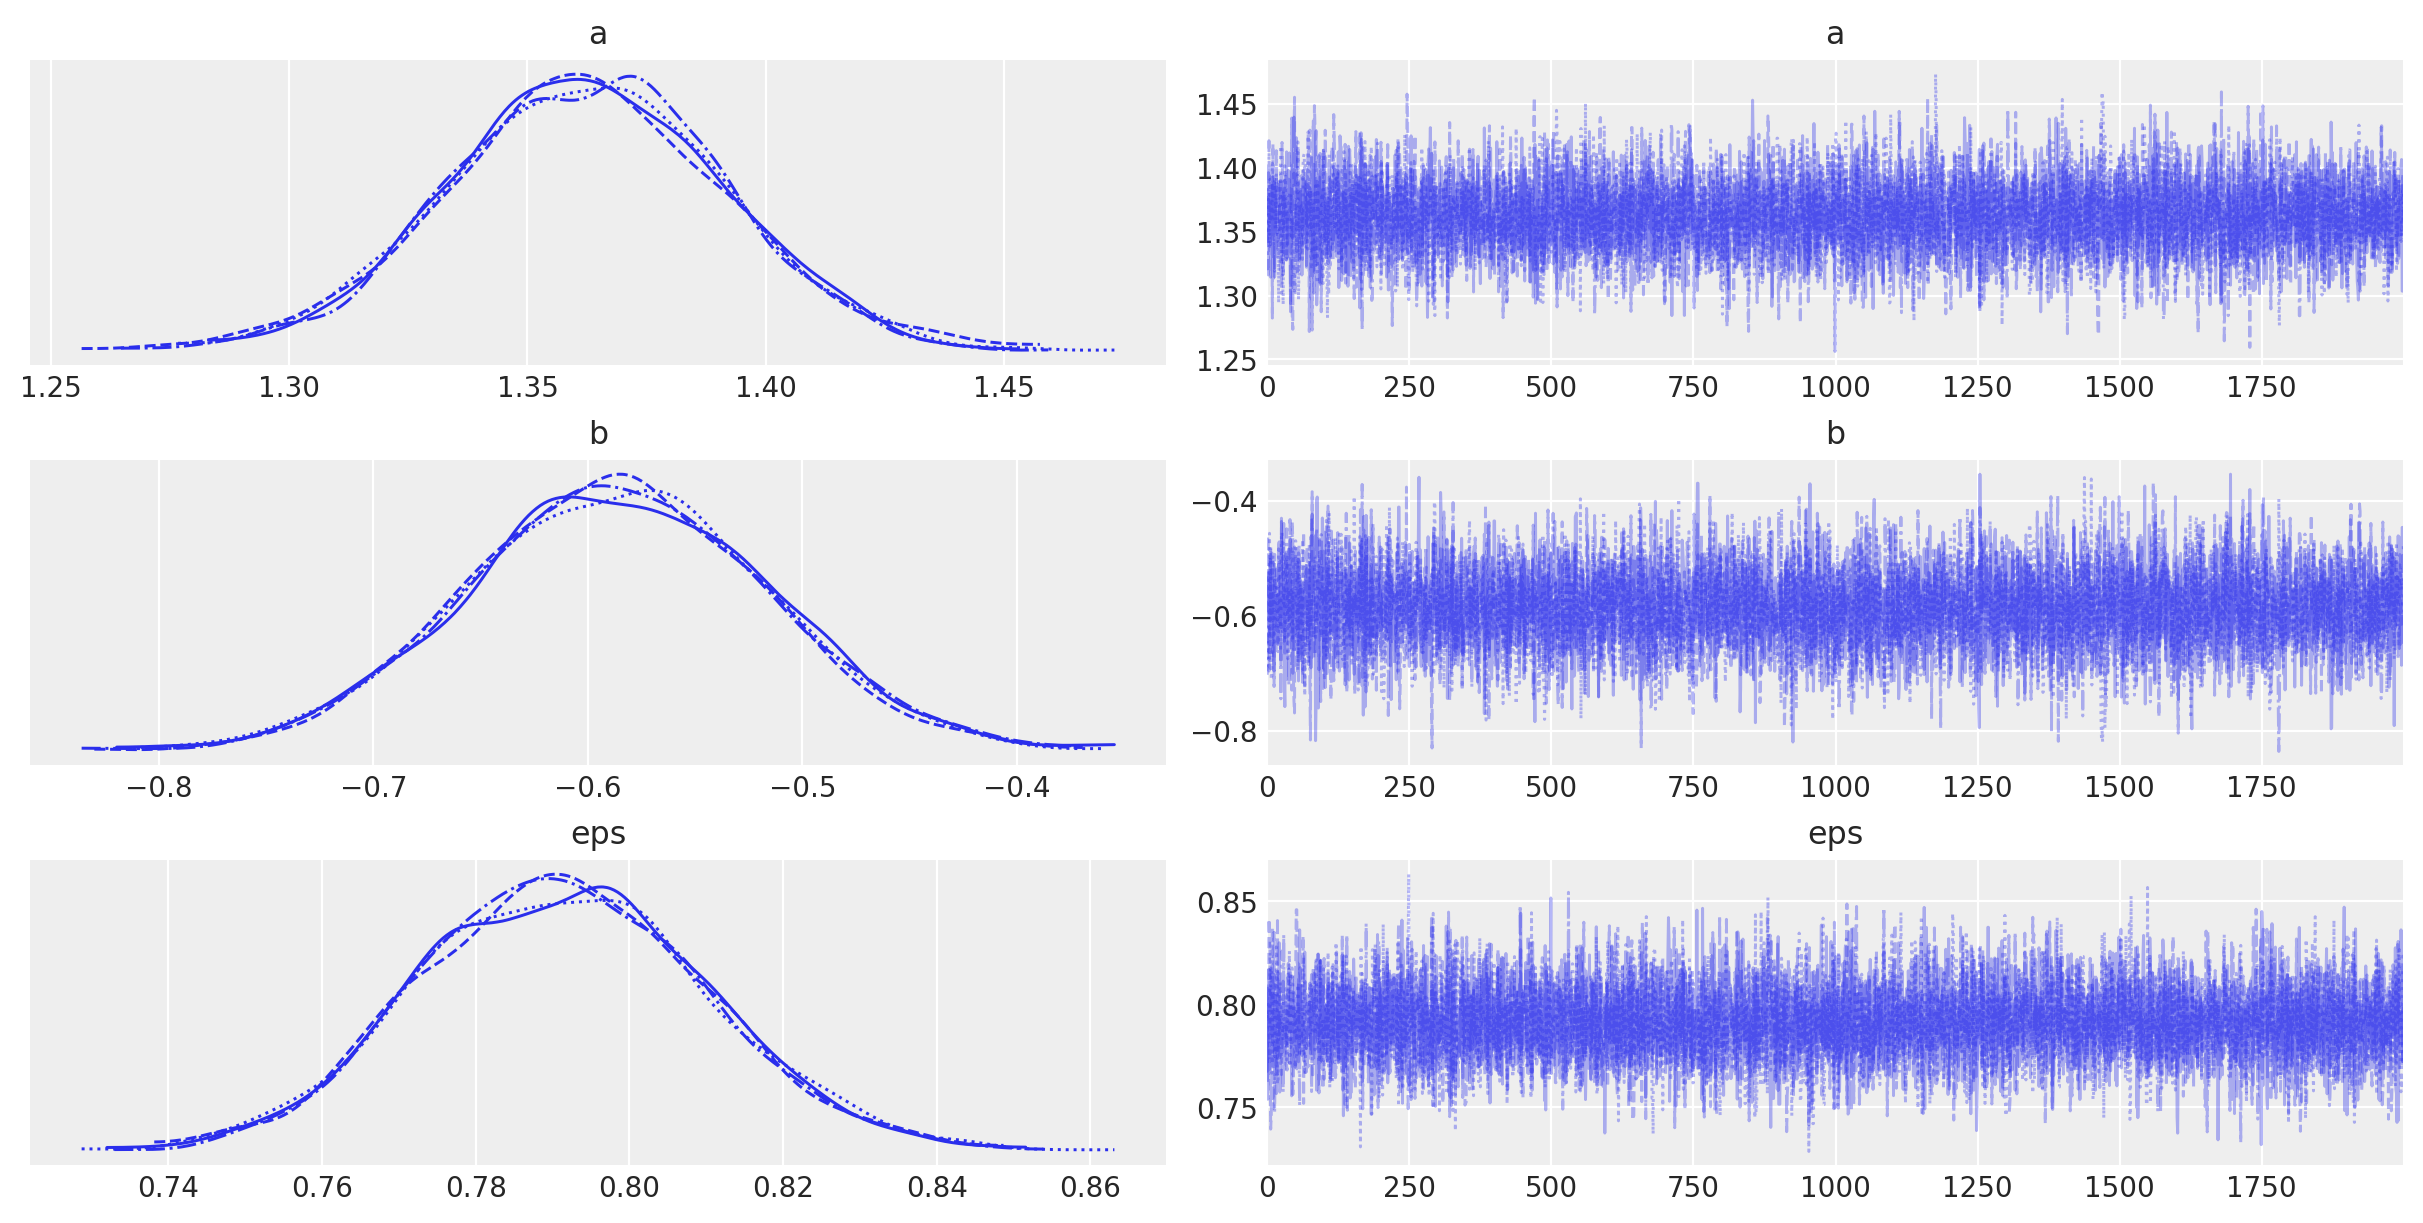

In [13]:
pm.plot_trace(pooled_trace, var_names=["a", "b", "eps"]);


# Unpooled/non-hierarchical model

In [14]:
with pm.Model() as unpooled_model:

    # Independent parameters for each county
    a = pm.Normal("a", 0, sigma=100, shape=n_counties)
    b = pm.Normal("b", 0, sigma=100, shape=n_counties)

    # Model error
    eps = pm.HalfCauchy("eps", 5)

    # Model prediction of radon level
    # a[county_idx] translates to a[0, 0, 0, 1, 1, ...],
    # we thus link multiple household measures of a county
    # to its coefficients.
    radon_est = a[county_idx] + b[county_idx] * data.floor.values

    # Data likelihood
    y = pm.Normal("y", radon_est, sigma=eps, observed=data.log_radon)

In [15]:
with unpooled_model:
    unpooled_trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.


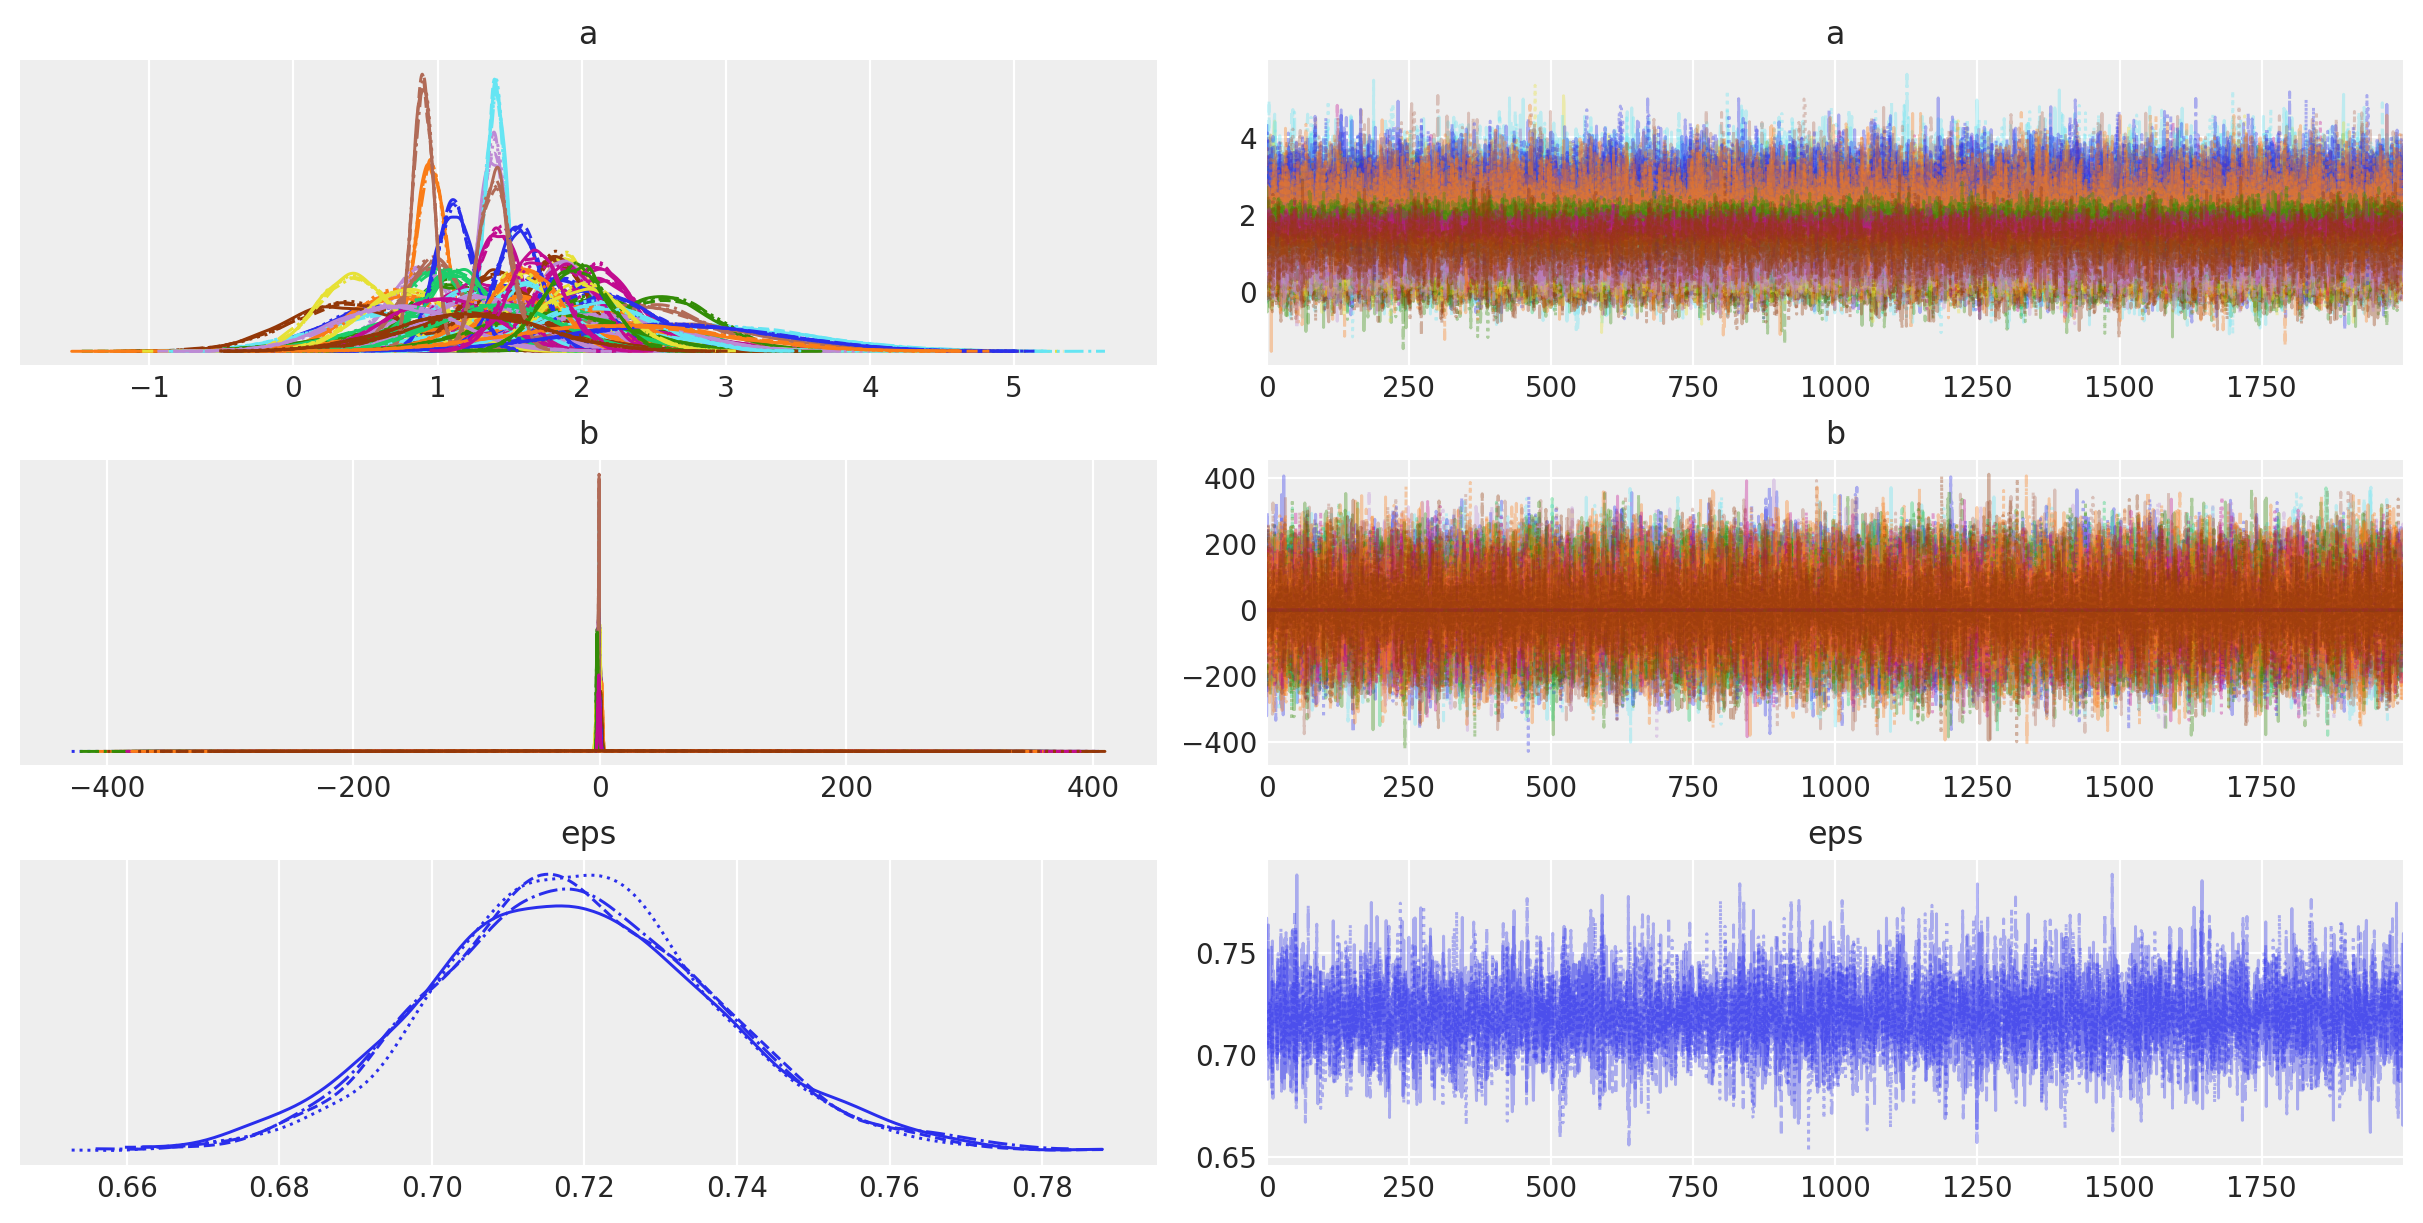

In [16]:
pm.plot_trace(unpooled_trace, var_names=["a", "b", "eps"]);

# Hierarchical model

In [17]:
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=100)
    sigma_a = pm.HalfNormal("sigma_a", 5.0)
    mu_b = pm.Normal("mu_b", mu=0.0, sigma=100)
    sigma_b = pm.HalfNormal("sigma_b", 5.0)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, shape=n_counties)
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal("b", mu=mu_b, sigma=sigma_b, shape=n_counties)

    # Model error
    eps = pm.HalfCauchy("eps", 5.0)

    radon_est = a[county_idx] + b[county_idx] * data.floor.values

    # Data likelihood
    y = pm.Normal("radon_like", mu=radon_est, sigma=eps, observed=data.log_radon)


In [18]:
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 38 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


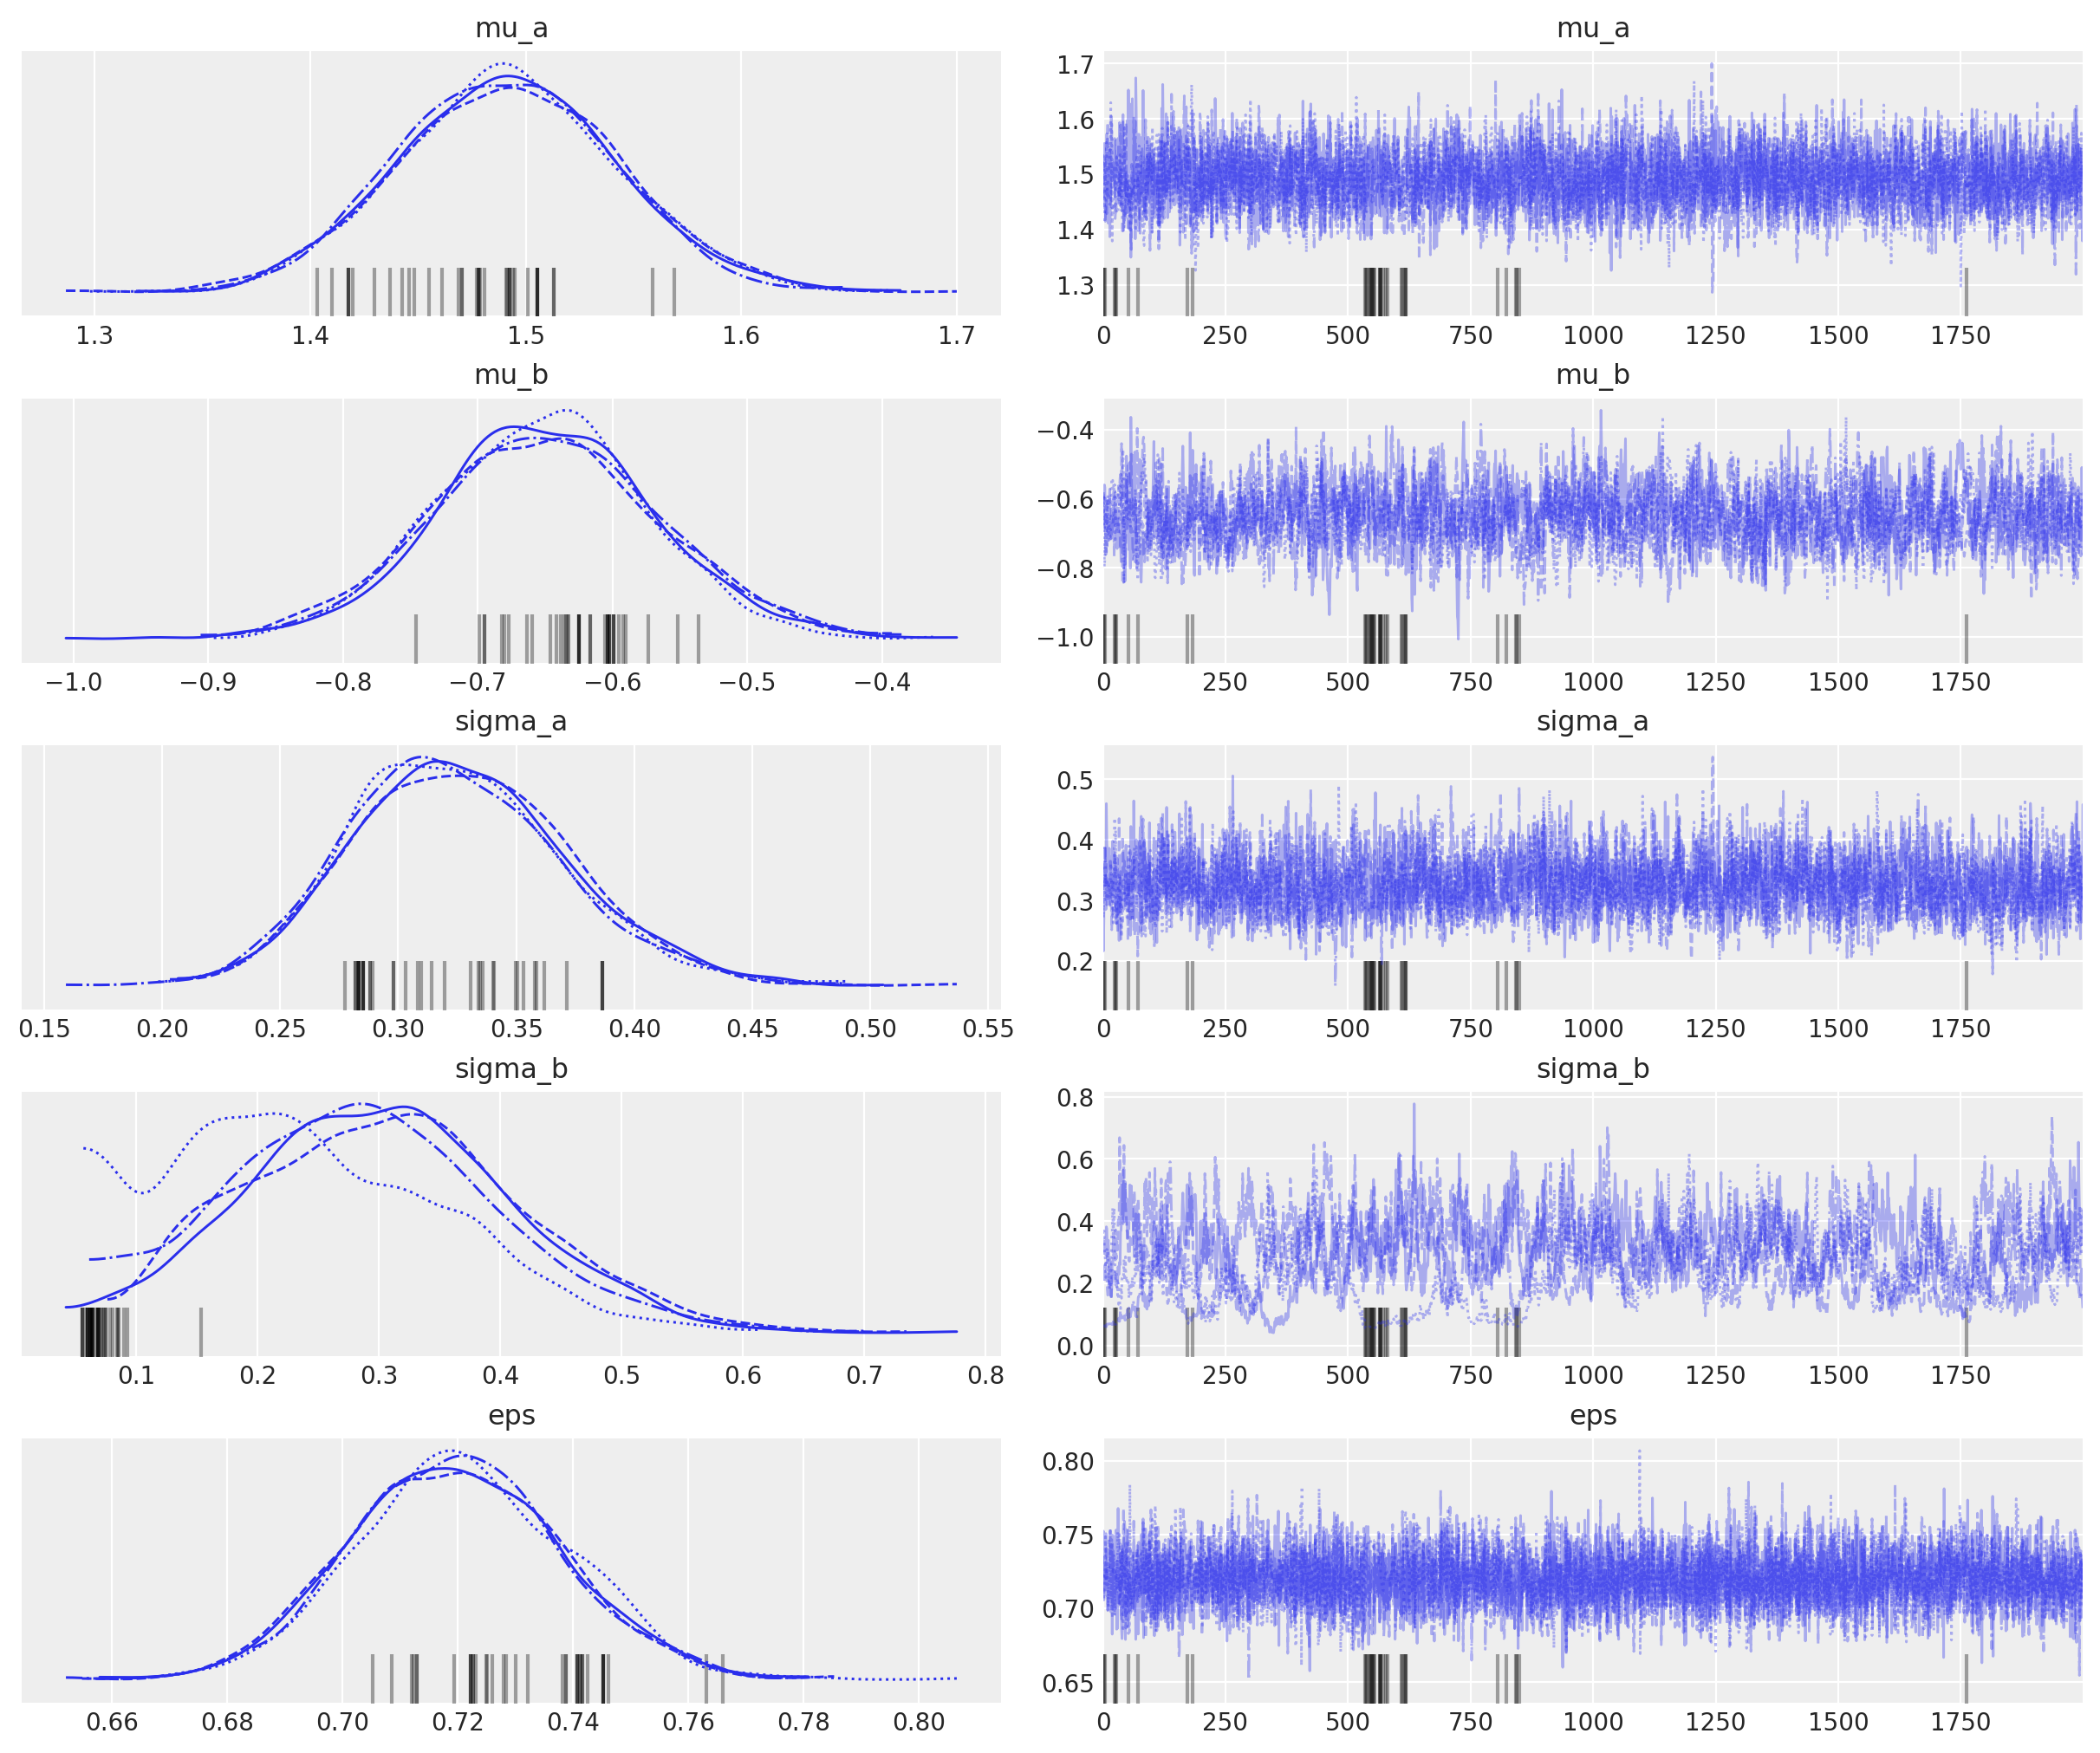

In [19]:
pm.plot_trace(hierarchical_trace, var_names=["mu_a", "mu_b", "sigma_a", "sigma_b", "eps"]);


# Watermark

In [20]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Aug 30 2021

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.25.0

arviz     : 0.11.2
sys       : 3.9.6 (default, Jun 29 2021, 05:25:02) 
[Clang 12.0.5 (clang-1205.0.22.9)]
matplotlib: 3.4.2
pymc3     : 3.11.2
theano    : 1.1.2
pandas    : 1.2.5
numpy     : 1.21.0
json      : 2.0.9

Watermark: 2.2.0

